In [168]:
import pandas as pd
import numpy as np
import os
os.chdir('D:/Downloads/vivienne/ML/Clustering&Retrieval_UW')
import matplotlib.pyplot as plt
%matplotlib inline
import json
from scipy.sparse import csr_matrix # sparse matrices

#Load in the dataset
wiki = pd.read_csv('people_wiki.csv')

#Extract word count vectors
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

word_count = load_sparse_csr('people_wiki_word_count.npz')
with open('people_wiki_map_index_to_word.json') as file:    
    map_index_to_word = json.load(file)

#Find nearest neighbors using word count vectors
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(metric='euclidean', algorithm='brute')
model.fit(word_count)

print(wiki[wiki['name'] == 'Barack Obama']) 
#35817th row: Obama

#NN to Obama
#1st arg: word count vector
distances, indices = model.kneighbors(word_count[35817], n_neighbors=10)

neighbors = pd.DataFrame(data={'distance':distances.flatten()},
                               index=indices.flatten())
#display the query results, the indices of and distances to the 10 NN
nearest_neighbors = wiki.join(neighbors)[['name', 'distance']].\
                    sort_values(by='distance', ascending=True)
nearest_neighbors.head(10)

#Interpret the nearest neighbors
def unpack_dict(matrix, map_index_to_word):
    table = sorted(map_index_to_word, key=map_index_to_word.get)
        
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    
    num_doc = matrix.shape[0]

    return [{k:v for k,v in zip([table[word_id] for word_id in \
                                 indices[indptr[i]:indptr[i+1]] ], \
                                 data[indptr[i]:indptr[i+1]].tolist())} \
            for i in range(num_doc) ]

wiki['word_count'] = unpack_dict(word_count, map_index_to_word)

                                              URI          name  \
35817  <http://dbpedia.org/resource/Barack_Obama>  Barack Obama   

                                                    text  
35817  barack hussein obama ii brk husen bm born augu...  


In [55]:
#A utility function displays a dictionary in tabular form
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia 
    page.
    """
    row = wiki[wiki['name'] == name]
    dict_word_count = row['word_count'].iloc[0]
    word_count_table = pd.DataFrame(list(dict_word_count.items()), 
                                    columns=['word','count'])                                     
    word_count_table = word_count_table.sort_values(by='count', 
                                                    ascending=False)
    return word_count_table

Obama_words = top_words('Barack Obama')
#print(obama_words)

Barrio_words = top_words('Francisco Barrio')
#print(barrio_words)

combined_words = Obama_words.set_index('word').\
                 join(Barrio_words.set_index('word'), 
                      lsuffix='_obama', rsuffix='_barrio')
combined_words.head(10)

,count_obama,count_barrio
word,,
the,40,36.0
in,30,17.0
and,21,18.0
of,18,24.0
to,14,9.0
his,11,5.0
obama,9,NaN
act,8,NaN
he,7,10.0


In [114]:
#Compute the sum of the result column to obtain # articles 
#containing all the 5 top words
common_words = set(['the', 'in', 'and', 'of', 'to'])
#cast to a set

def has_top_words(word_count_vector):
    #extract the keys of word_count_vector and convert it to a set
    unique_words = set(word_count_vector.keys())
    #return True if common_words is a subset of unique_words
    #return False otherwise
    return common_words.issubset(unique_words) 
    #set.issubset(SET)

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)

#use has_top_words column to answer the quiz question
wiki.head(10)
print(sum(wiki['has_top_words'] == True))

#Check has_top_words function on two random articles
print('Output from your function:', has_top_words(wiki.iloc[32]['word_count']))
print('Correct output: True')
print('Also check the length of unique_words. It should be 167')

print('Output from your function:', has_top_words(wiki.iloc[33]['word_count']))
print('Correct output: False')
print('Also check the length of unique_words. It should be 188')


56066
Output from your function: True
Correct output: True
Also check the length of unique_words. It should be 167
Output from your function: False
Correct output: False
Also check the length of unique_words. It should be 188


In [85]:
#Measure the pairwise distance between the Wikipedia pages of 
#Barack Obama, George W. Bush, and Joe Biden
from sklearn.metrics.pairwise import euclidean_distances
BG_dist = euclidean_distances(word_count[wiki.index[wiki['name']=='Barack Obama'].tolist()], 
                              word_count[wiki.index[wiki['name']=='George W. Bush'].tolist()])
BJ_dist = euclidean_distances(word_count[wiki.index[wiki['name']=='Barack Obama'].tolist()], 
                              word_count[wiki.index[wiki['name']=='Joe Biden'].tolist()])
GJ_dist = euclidean_distances(word_count[wiki.index[wiki['name']=='George W. Bush'].tolist()], 
                              word_count[wiki.index[wiki['name']=='Joe Biden'].tolist()])
#print(BG_dist, BJ_dist, GJ_dist)

#Collect all words that appear both in Barack Obama and George W. Bush pages. 
#Out of those words, find the 10 words that show up most often in Obama's page.
Bush_words = top_words('George W. Bush')
Obama_Bush = Obama_words.set_index('word').join(Bush_words.set_index('word'), 
                                                lsuffix='_obama', rsuffix='_bush')
Obama_Bush = Obama_Bush.rename(index=str, 
                               columns={'count_obama':'Obama', 
                                        'count_bush':'Bush'})
#Obama_Bush.index = words -- object/string
Obama_Bush = Obama_Bush.sort_values(by='Obama', ascending=False)
Obama_Bush = Obama_Bush.dropna()
Obama_Bush.head(10)

,Obama,Bush
word,,
the,40,39.0
in,30,22.0
and,21,14.0
of,18,14.0
to,14,11.0
his,11,6.0
act,8,3.0
a,7,6.0
he,7,8.0


In [101]:
'''
To retrieve articles that are more relevant, 
we should focus more on rare words that don't happen in every article. 
TF-IDF (term frequency–inverse document frequency) is a feature representation 
that penalizes words that are too common.
'''
#Extract the TF-IDF vectors
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')
#load in the TF-IDF vectors
wiki['tf_idf'] = unpack_dict(tf_idf, map_index_to_word)
#store the TF-IDF vectors in dictionary form

'''
#Extract the TF-IDF manually
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer
corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?',
          ]
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
'''

#Find nearest neighbors using TF-IDF vectors to Obama's page
model_tf_idf = NearestNeighbors(metric='euclidean', algorithm='brute')
model_tf_idf.fit(tf_idf)
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=10)
neighbors = pd.DataFrame(data={'distance':distances.flatten()},
                               index=indices.flatten())
print(wiki.join(neighbors).sort_values(by='distance', ascending = True)\
      [['name','distance']][0:10])

                          name    distance
35817             Barack Obama    0.000000
7914             Phil Schiliro  106.861014
46811            Jeff Sessions  108.871674
44681   Jesse Lee (politician)  109.045698
38376           Samantha Power  109.108106
6507              Bob Menendez  109.781867
38714  Eric Stern (politician)  109.957788
44825           James A. Guest  110.413889
44368     Roland Grossenbacher  110.470609
33417            Tulsi Gabbard  110.696998


In [127]:
def top_words_tf_idf(name):
    row = wiki[wiki['name'] == name]
    dict_word_weight = row['tf_idf'].iloc[0]
    word_weight_table = pd.DataFrame(list(dict_word_weight.items()), 
                                     columns=['word','weight'])                                     
    word_weight_table = word_weight_table.sort_values(by='weight', 
                                                     ascending=False)
    return word_weight_table

Obama_tf_idf = top_words_tf_idf('Barack Obama')
#print(Obama_tf_idf)

Schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')
#print(Schiliro_tf_idf)

combined_tf_idf = Obama_tf_idf.set_index('word').\
                  join(Schiliro_tf_idf.set_index('word'), 
                       lsuffix='_obama', rsuffix='_schiliro')
combined_tf_idf = combined_tf_idf.rename(
                  index=str, columns={'weight_obama':'Obama', 
                                      'weight_schiliro':'Schiliro'})
combined_tf_idf = combined_tf_idf.sort_values(by='Obama', 
                                              ascending=False)
combined_tf_idf = combined_tf_idf.dropna()
combined_tf_idf.head(10)

,Obama,Schiliro
word,,
obama,43.295653,9.621256
law,14.722936,7.361468
democratic,12.410689,6.205344
senate,10.164288,3.388096
presidential,7.386955,3.693478
president,7.226869,9.033587
policy,6.095386,3.047693
states,5.473201,1.824400
office,5.248173,2.624086


In [115]:
#Among the words that appear in both Barack Obama and Phil Schiliro, 
#take the 5 that have largest weights in Obama. 
#Compute the sum of the result column to obtain # articles 
#containing all the 5 top words
common_words_tf_idf = set(['obama', 'law', 'democratic', 'senate', 
                           'presidential'])
def has_top_words_tf_idf(word_count_vector):
    #extract the keys of word_count_vector and convert it to a set
    unique_words = set(word_count_vector.keys())
    #return True if common_words is a subset of unique_words
    #return False otherwise
    return common_words_tf_idf.issubset(unique_words) 
    #set.issubset(SET)

wiki['has_top_words_tf_idf'] = wiki['word_count'].\
                               apply(has_top_words_tf_idf)

#use has_top_words_tf_idf column to answer the quiz question
wiki.head(10)
print(sum(wiki['has_top_words_tf_idf'] == True))
#There is a huge difference in this calculation using TF-IDF scores instead of raw word counts. 
#Since noise has been eliminated noise arising from extremely common words.

14


In [135]:
#Choose metric
#Compute the Euclidean distance between TF-IDF features of Obama and Biden
BJ_dist_tf_idf = euclidean_distances(tf_idf[wiki.index[wiki['name']==\
                                                       'Barack Obama'].tolist()], 
                                     tf_idf[wiki.index[wiki['name']==\
                                                       'Joe Biden'].tolist()])
print(BJ_dist_tf_idf)
#The distance is larger than the distances we found for the 10 nearest neighbors.
'''
It turns out that, nearest neighbors using the Euclidean distances,
unwittingly favors short articles over long ones.
'''

#Comptue length of each Wikipedia doc
def compute_length(row):
    return len(row['text'].split(' '))
wiki['length'] = wiki.apply(compute_length, axis=1)

#Compute 100 nearest neighbors and display their lengths compared to Obama's page
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = pd.DataFrame(data={'distance':distances.flatten()},
                               index=indices.flatten())
nearest_neighbors_euclidean = wiki.join(neighbors)[['name','length','distance']].\
                              sort_values(by='distance', ascending = True)    
nearest_neighbors_euclidean.head(10)

[[ 123.29745601]]


,name,length,distance
35817,Barack Obama,540,0.000000
7914,Phil Schiliro,208,106.861014
46811,Jeff Sessions,230,108.871674
44681,Jesse Lee (politician),216,109.045698
38376,Samantha Power,310,109.108106
6507,Bob Menendez,220,109.781867
38714,Eric Stern (politician),255,109.957788
44825,James A. Guest,215,110.413889
44368,Roland Grossenbacher,201,110.470609
33417,Tulsi Gabbard,228,110.696998


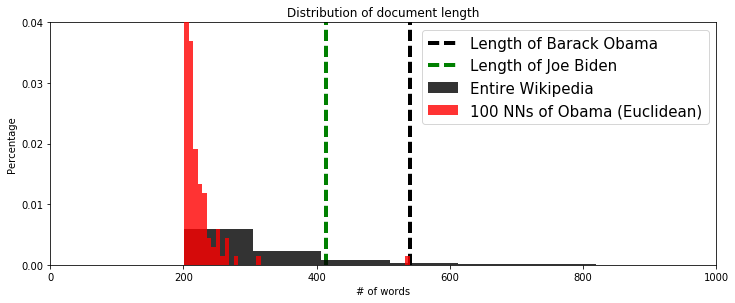

In [139]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled',
         normed=True, label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'][:100], 50, color='r', edgecolor='None', 
         histtype='stepfilled', normed=True, label='100 NNs of Obama (Euclidean)', 
         zorder=10, alpha=0.8)
#nearest_neighbors_euclidean[:100]=head(100) from the 1st to 100th
#[10:] from 10th to the last
#[-10:]=tail(10) from the 10th last to the last one
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'].tolist()[0], color='k', 
            linestyle='--', linewidth=4, label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'].tolist()[0], color='g', 
            linestyle='--', linewidth=4, label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()
'''
Both word-count features and TF-IDF are proportional to word frequencies. 
While TF-IDF penalizes very common words, 
longer articles tend to have longer TF-IDF vectors simply because they have more words in them.
'''

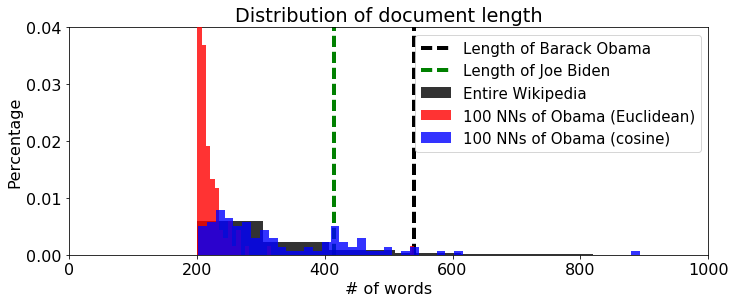

In [153]:
#Use cosine distance to remove the bias of word frequency
'''
Cosine distances compare word distributions of two articles of varying lengths
'''
model2_tf_idf = NearestNeighbors(algorithm='brute', metric='cosine')
model2_tf_idf.fit(tf_idf)
distances, indices = model2_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = pd.DataFrame(data={'distance':distances.flatten()},
                               index=indices.flatten())
nearest_neighbors_cosine = wiki.join(neighbors)[['name','length','distance']].\
                           sort_values(by='distance', ascending = True)                        
nearest_neighbors_cosine.head(10)

#Visualization
plt.figure(figsize=(10.5,4.5))
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', 
         normed=True, label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'][:100], 50, color='r', 
         edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.hist(nearest_neighbors_cosine['length'][:100], 50, color='b', 
         edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (cosine)', zorder=11, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'].tolist()[0], 
            color='k', linestyle='--', linewidth=4,
            label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'].tolist()[0], 
            color='g', linestyle='--', linewidth=4,
            label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

In [166]:
'''
Cosine distances ignore all document lengths, 
which may be great in certain situations but not in others
'''
#Problem with cosine distances: tweets vs. long articles
tweet = {'act': 3.4597778278724887,
         'control': 3.721765211295327,
         'democratic': 3.1026721743330414,
         'governments': 4.167571323949673,
         'in': 0.0009654063501214492,
         'law': 2.4538226269605703,
         'popular': 2.764478952022998,
         'response': 4.261461747058352,
         'to': 0.04694493768179923}

#TF-IDF vectors for this tweet
word_indices = []
for word in tweet.keys():
    if word in map_index_to_word.keys():
        word_indices.append(map_index_to_word[word])

tweet_tf_idf = csr_matrix((list(tweet.values()), 
                          ([0]*len(word_indices), word_indices)),
                          shape=(1, tf_idf.shape[1]))

#compute the cosine distance between the Barack Obama article and this tweet
from sklearn.metrics.pairwise import cosine_distances
Otweet_dist_tf_idf_cosine = cosine_distances(tf_idf[35817], tweet_tf_idf))
print(Otweet_dist_tf_idf_cosine)

#compare this distance to the distance between the Barack Obama article 
#and all of its Wikipedia 10 nearest neighbors
distances, indices = model2_tf_idf.kneighbors(tf_idf[35817], n_neighbors=10)
print(distances)

[[ 0.70591838]]
[[ 0.          0.70313868  0.7429819   0.7583584   0.77056123  0.7846775
   0.78803907  0.79092642  0.7983226   0.79946636]]
